## Yahoo Fundamental

## STOCKS



In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import talib
import math
from datetime import datetime, timedelta
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from bs4 import BeautifulSoup
import requests
from django.core.validators import RegexValidator
from django.http import JsonResponse, Http404
import pandas as pd
import matplotlib.pyplot as plt

# S&P 500 → ^GSPC
# Dow Jones → ^DJI
# Nasdaq 100 → ^NDX
# Russell 2000 → ^RUT
# DAX (Alemanha) → ^GDAXI
# Definir o ticker da ação
symbol = "AAPL"  # Apple Inc.
# symbol = "^GSPC"  # Apple Inc.
# symbol = "XLK"  # Apple Inc.

# Definir período e intervalo
period = "1y"       # Período de 1 mês
interval = "1d"      # Dados diários


In [55]:
yahoo_symbol_info = yf.Ticker(symbol).info
yahoo_symbol_balancesheet = yf.Ticker(symbol).balance_sheet
yahoo_symbol_balancesheet_quarter = yf.Ticker(symbol).quarterly_balance_sheet
yahoo_symbol_income = yf.Ticker(symbol).income_stmt
yahoo_symbol_income_quarter = yf.Ticker(symbol).quarterly_income_stmt
yahoo_symbol_cashflow = yf.Ticker(symbol).cash_flow
yahoo_symbol_cashflow_quarter = yf.Ticker(symbol).quarterly_cash_flow

In [57]:
yahoo_symbol_info.get("beta")

1.109

In [60]:
beta = yahoo_symbol_info.get("beta")
interest_expense_ttm = yahoo_symbol_income.loc["Interest Expense"].dropna().iloc[0]
total_debt = yahoo_symbol_balancesheet.loc["Total Debt"].dropna().iloc[0]

cd = interest_expense_ttm / total_debt

tax_provisory_ttm = yahoo_symbol_income_quarter.loc['Tax Provision'].sum()
pretax_income_ttm = yahoo_symbol_income_quarter.loc['Pretax Income'].sum()
tax_efective = tax_provisory_ttm / pretax_income_ttm 

market_cap = yahoo_symbol_info.get('marketCap')

us10y = yf.Ticker("^TNX").info.get("previousClose") / 100
erp = 0.055

ce = us10y + beta * erp

wacc = ((market_cap / (market_cap + total_debt)) * ce) + ((total_debt / (total_debt + market_cap)) * cd * (1 - tax_efective))

In [61]:
wacc

np.float64(0.09949293484241893)

In [36]:
yahoo_symbol_cashflow_quarter.T.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6 entries, 2025-06-30 to 2024-03-31
Data columns (total 46 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Free Cash Flow                                  5 non-null      float64
 1   Repurchase Of Capital Stock                     5 non-null      float64
 2   Repayment Of Debt                               5 non-null      float64
 3   Issuance Of Debt                                1 non-null      float64
 4   Capital Expenditure                             5 non-null      float64
 5   Income Tax Paid Supplemental Data               5 non-null      float64
 6   End Cash Position                               5 non-null      float64
 7   Beginning Cash Position                         5 non-null      float64
 8   Changes In Cash                                 5 non-null      float64
 9   Financing Cash Flow       

In [44]:
yahoo_symbol_income_quarter.T.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5 entries, 2025-06-30 to 2024-06-30
Data columns (total 33 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Tax Effect Of Unusual Items                                 5 non-null      float64
 1   Tax Rate For Calcs                                          5 non-null      float64
 2   Normalized EBITDA                                           5 non-null      float64
 3   Net Income From Continuing Operation Net Minority Interest  5 non-null      float64
 4   Reconciled Depreciation                                     5 non-null      float64
 5   Reconciled Cost Of Revenue                                  5 non-null      float64
 6   EBITDA                                                      5 non-null      float64
 7   EBIT                                                        5 non-null  

In [38]:
yahoo_symbol_balancesheet_quarter.T.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6 entries, 2025-06-30 to 2023-12-31
Data columns (total 65 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Treasury Shares Number                               1 non-null      float64
 1   Ordinary Shares Number                               5 non-null      float64
 2   Share Issued                                         5 non-null      float64
 3   Net Debt                                             5 non-null      float64
 4   Total Debt                                           5 non-null      float64
 5   Tangible Book Value                                  5 non-null      float64
 6   Invested Capital                                     5 non-null      float64
 7   Working Capital                                      5 non-null      float64
 8   Net Tangible Assets                                  

In [34]:
total_revenue = yahoo_symbol_income_quarter.loc['Total Revenue']
total_revenue.sum()

np.float64(494402000000.0)

In [35]:
ebit_ttm = yahoo_symbol_income_quarter.loc["EBIT"].sum()

if 'Total Revenue' in yahoo_symbol_income_quarter.index:
    total_revenue = yahoo_symbol_income_quarter.loc['Total Revenue']
    if pd.isna(total_revenue).all():
        total_revenue = None


total_revenue_ttm = total_revenue.sum()

operation_margin = ebit_ttm / total_revenue_ttm if total_revenue_ttm is not None and total_revenue_ttm > 0 else None
ebit_ttm, total_revenue_ttm, operation_margin

(np.float64(155566000000.0),
 np.float64(494402000000.0),
 np.float64(0.31465487599160197))

In [27]:
interest_coverage_ebit

In [4]:
yahoo_data_earnings_history = yf.Ticker(symbol).earnings_history
yahoo_data_earnings_estimate = yf.Ticker(symbol).earnings_estimate
yahoo_data_earnings_dates = yf.Ticker(symbol).earnings_dates

In [5]:
yahoo_data_earnings_dates

,EPS Estimate,Reported EPS,Surprise(%),Event Type
Earnings Date,,,,
2025-05-01 16:30:00-04:00,1.63,1.65,1.41,Earnings
2025-02-27 12:00:00-05:00,NaN,NaN,NaN,Meeting
2025-01-30 16:31:00-05:00,2.35,2.40,2.15,Earnings
2024-10-31 16:31:00-04:00,1.60,1.64,2.35,Earnings
2024-08-01 16:30:00-04:00,1.35,1.40,3.99,Earnings
2024-05-02 16:31:00-04:00,1.50,1.53,1.97,Earnings
2024-02-01 16:00:00-05:00,2.10,2.18,3.90,Earnings
2023-11-02 16:30:00-04:00,1.39,1.46,4.92,Earnings
2023-08-03 16:30:00-04:00,1.19,1.26,5.49,Earnings


In [9]:
yahoo_data_earnings_dates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2025-05-01 16:30:00-04:00 to 2022-10-27 16:30:00-04:00
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   EPS Estimate  11 non-null     float64
 1   Reported EPS  11 non-null     float64
 2   Surprise(%)   11 non-null     float64
 3   Event Type    12 non-null     object 
dtypes: float64(3), object(1)
memory usage: 480.0+ bytes


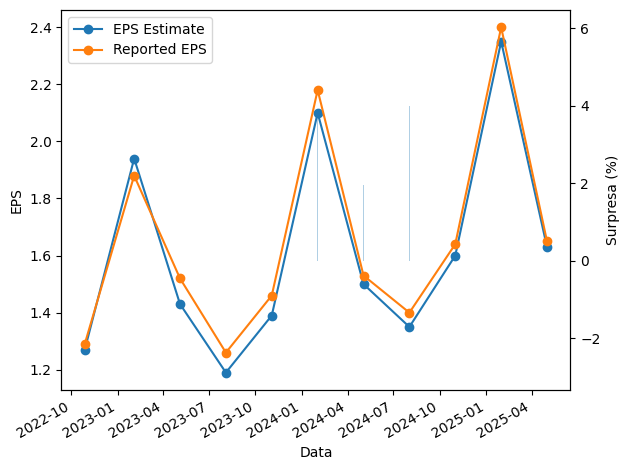

In [ ]:

# --- assume que seu DataFrame já se chama df ---
# Índice é DatetimeIndex (com ou sem timezone). Garanta a ordem cronológica:
df_plot = yahoo_data_earnings_dates.sort_index()

# Filtra apenas eventos de Earnings
df_plot = df_plot[df_plot["Event Type"] == "Earnings"].copy()

# (opcional) se quiser nomes mais curtos no eixo X
# df_plot.index = df_plot.index.tz_convert('UTC') if df_plot.index.tz is not None else df_plot.index

fig, ax1 = plt.subplots()

# Linhas de EPS
ax1.plot(df_plot.index, df_plot["EPS Estimate"], marker="o", label="EPS Estimate")
ax1.plot(df_plot.index, df_plot["Reported EPS"], marker="o", label="Reported EPS")
ax1.set_xlabel("Data")
ax1.set_ylabel("EPS")
ax1.legend(loc="upper left")

# Barras de Surpresa (%) num eixo secundário
ax2 = ax1.twinx()
ax2.bar(df_plot.index, df_plot["Surprise(%)"], alpha=0.35)
ax2.set_ylabel("Surpresa (%)")

fig.autofmt_xdate()
fig.tight_layout()
plt.show()

In [12]:
yahoo_data_earnings_history

,epsActual,epsEstimate,epsDifference,surprisePercent
quarter,,,,
2024-09-30,0.97,0.94654,0.02,0.0248
2024-12-31,2.40,2.34102,0.06,0.0252
2025-03-31,1.65,1.62253,0.03,0.0169
2025-06-30,1.57,1.42572,0.14,0.1012


In [18]:
!pip install nbformat


In [13]:
yahoo_data_earnings_estimate

,avg,low,high,yearAgoEps,numberOfAnalysts,growth
period,,,,,,
0q,1.75840,1.63,1.82,0.97000,26,0.8128
+1q,2.46401,2.29,2.67,2.40000,22,0.0267
0y,7.38321,7.25,7.47,6.08000,35,0.2143
+1y,7.94575,7.13,9.00,7.38321,38,0.0762


In [23]:
def get_sector_etf_info(sector: str, search_value: str = "info"):
        """
        Return information about symbol ETF sector.
        """
        sector_map = {
            "Technology": "XLK",
            "Financial Services": "XLF",
            "Consumer Cyclical": "XLY",
            "Healthcare": "XLV",
            "Communication Services": "XLC",
            "Industrials": "XLI",
            "Consumer Defensive": "XLP",
            "Energy": "XLE",
            "Real Estate": "XLRE",
            "Basic Materials": "XLB",
            "Utilities": "XLU",
        }

        etf_symbol = sector_map.get(sector)
        if not etf_symbol:
            return "NaN"

        ticker = yf.Ticker(etf_symbol)

        if search_value == "info":
            return ticker.info
        else:
            return ticker.info.get(search_value, "NaN")

In [24]:
# sector = get_sector_etf_info('Utilities')
# sector